
DIAGNOSTIC WIRE SEGMENTATION
IMAGE ANALYSIS
Image shape: (1600, 1200, 3)
Image mode: RGB
Data type: uint8
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 107.30
Std pixel value: 58.84
Red channel - Mean: 116.79, Std: 61.56
Green channel - Mean: 109.92, Std: 59.37
Blue channel - Mean: 95.18, Std: 53.19

Loading model...


Model loaded successfully!

Trying different preprocessing methods...

Processing with standard preprocessing...

Processing with equalized preprocessing...

Processing with clahe preprocessing...

Processing with enhanced_contrast preprocessing...

Processing with gamma_corrected preprocessing...

Generating diagnostic visualizations...


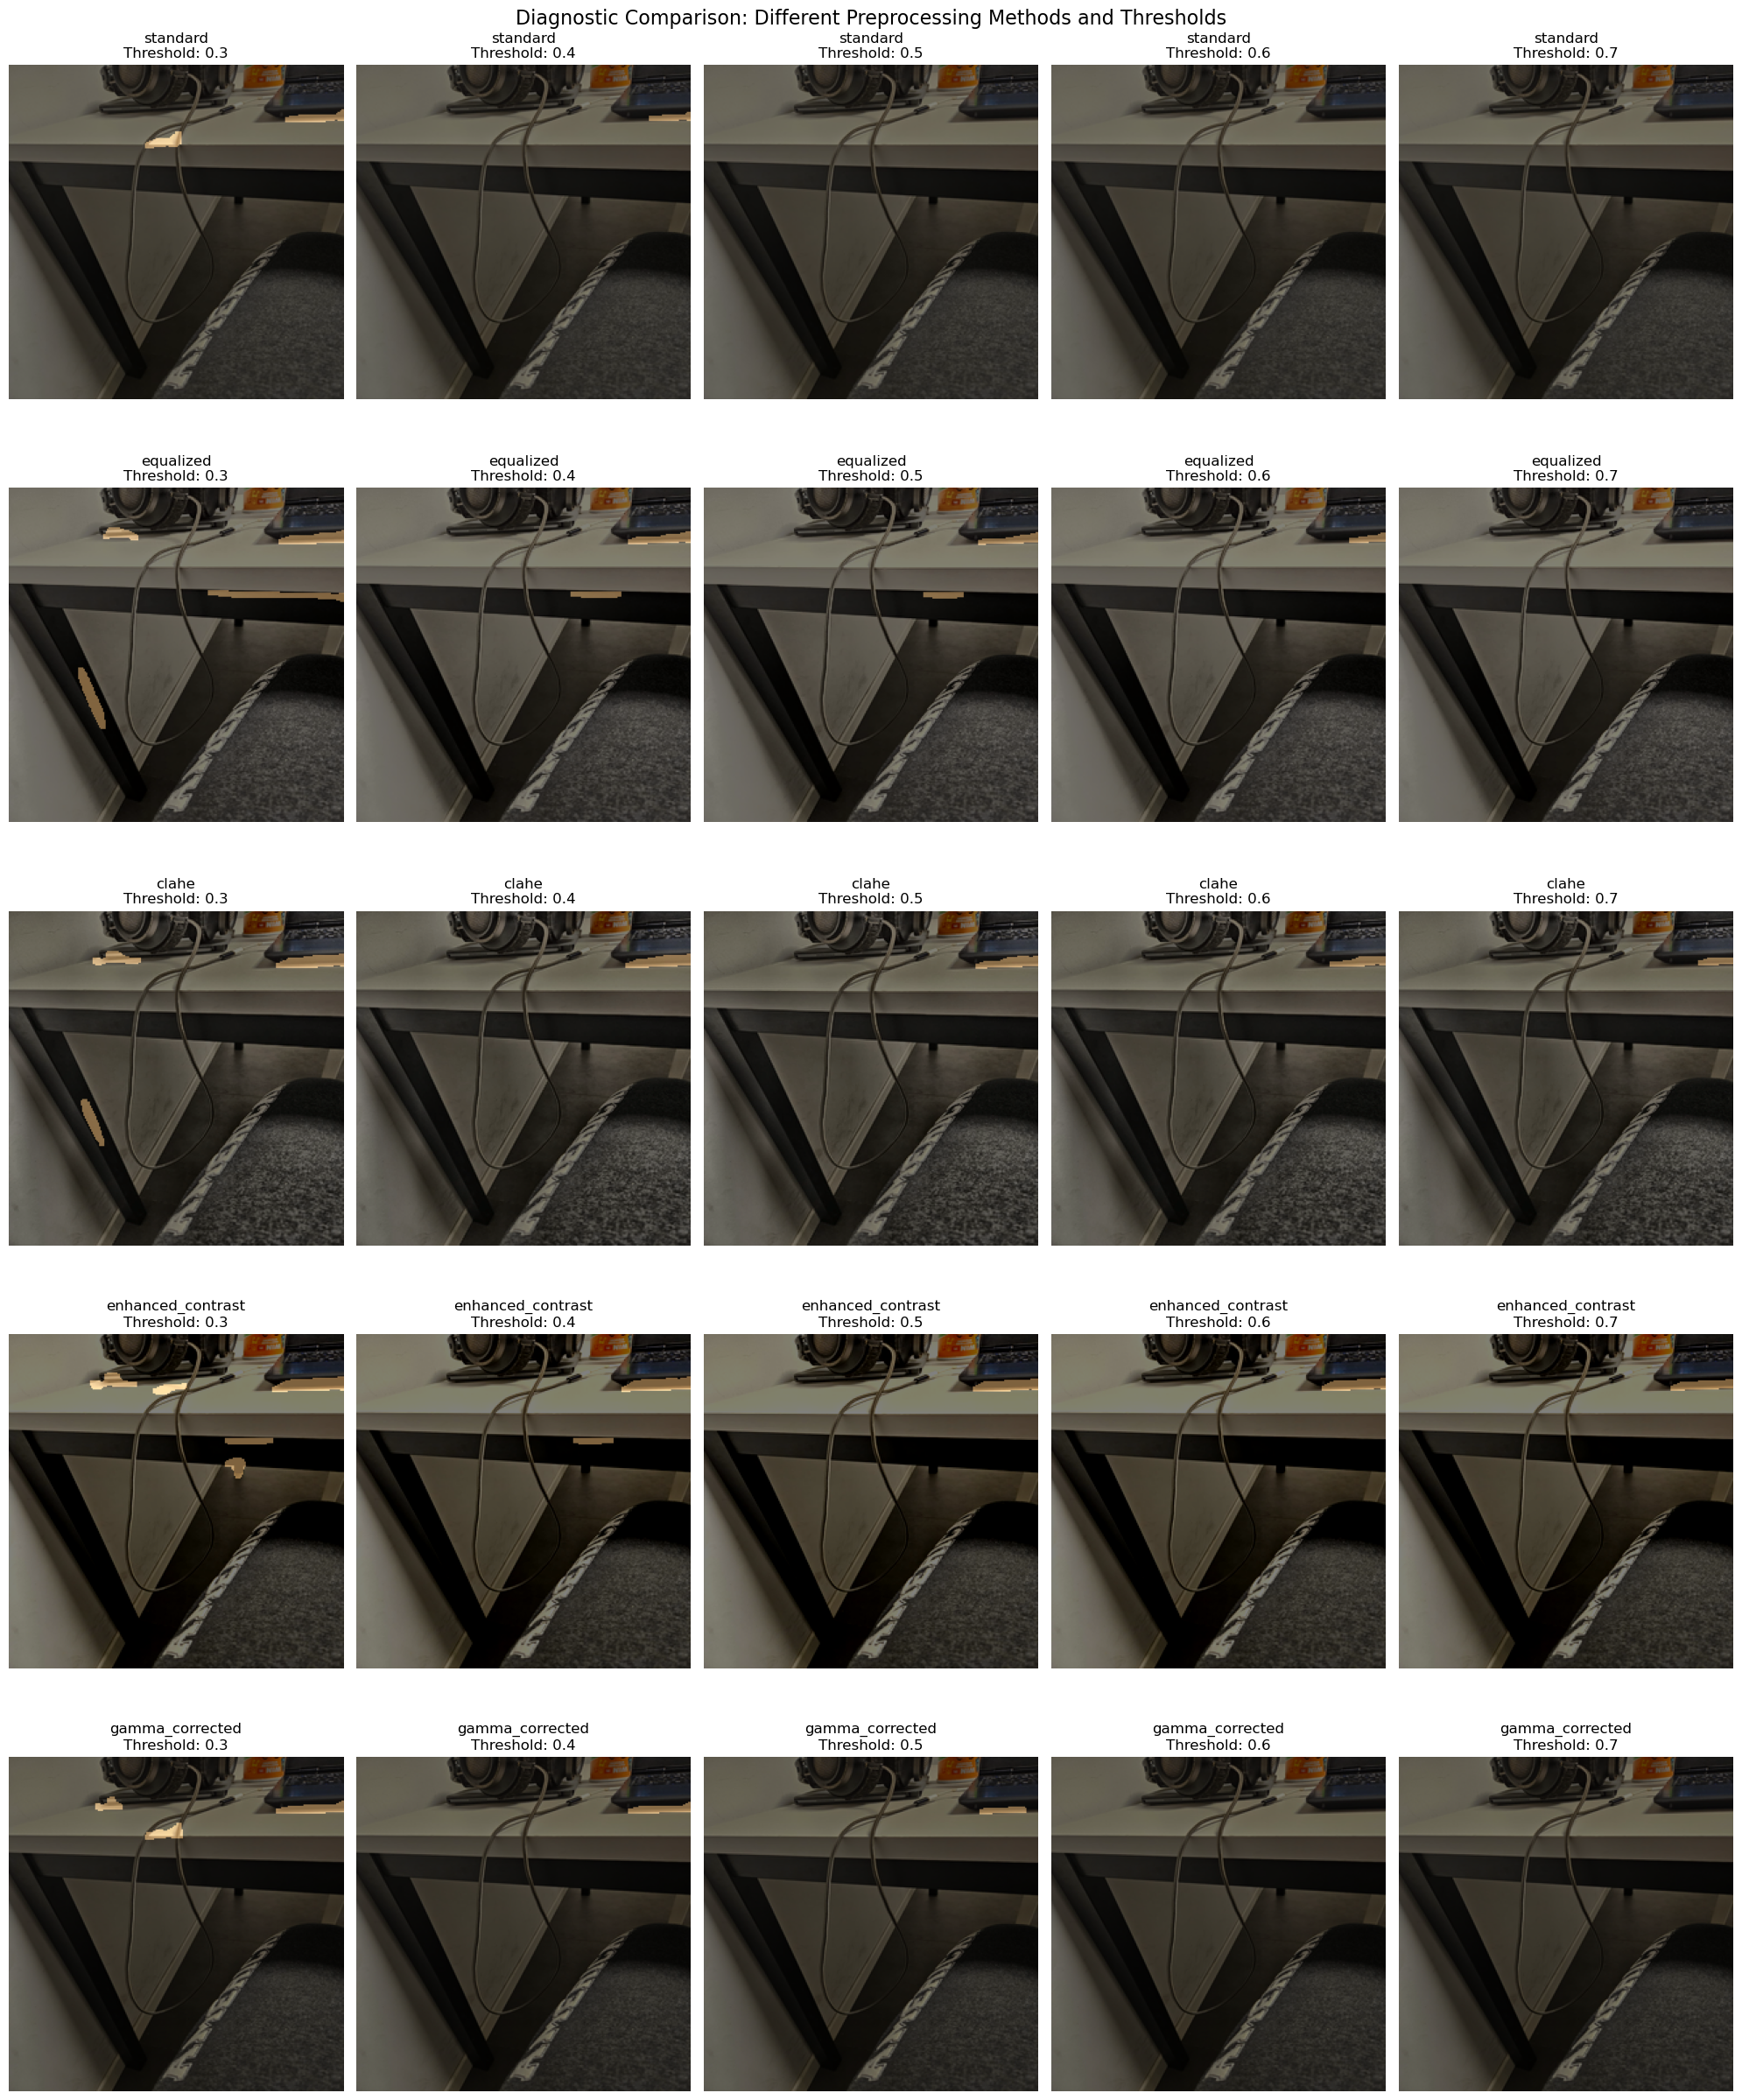

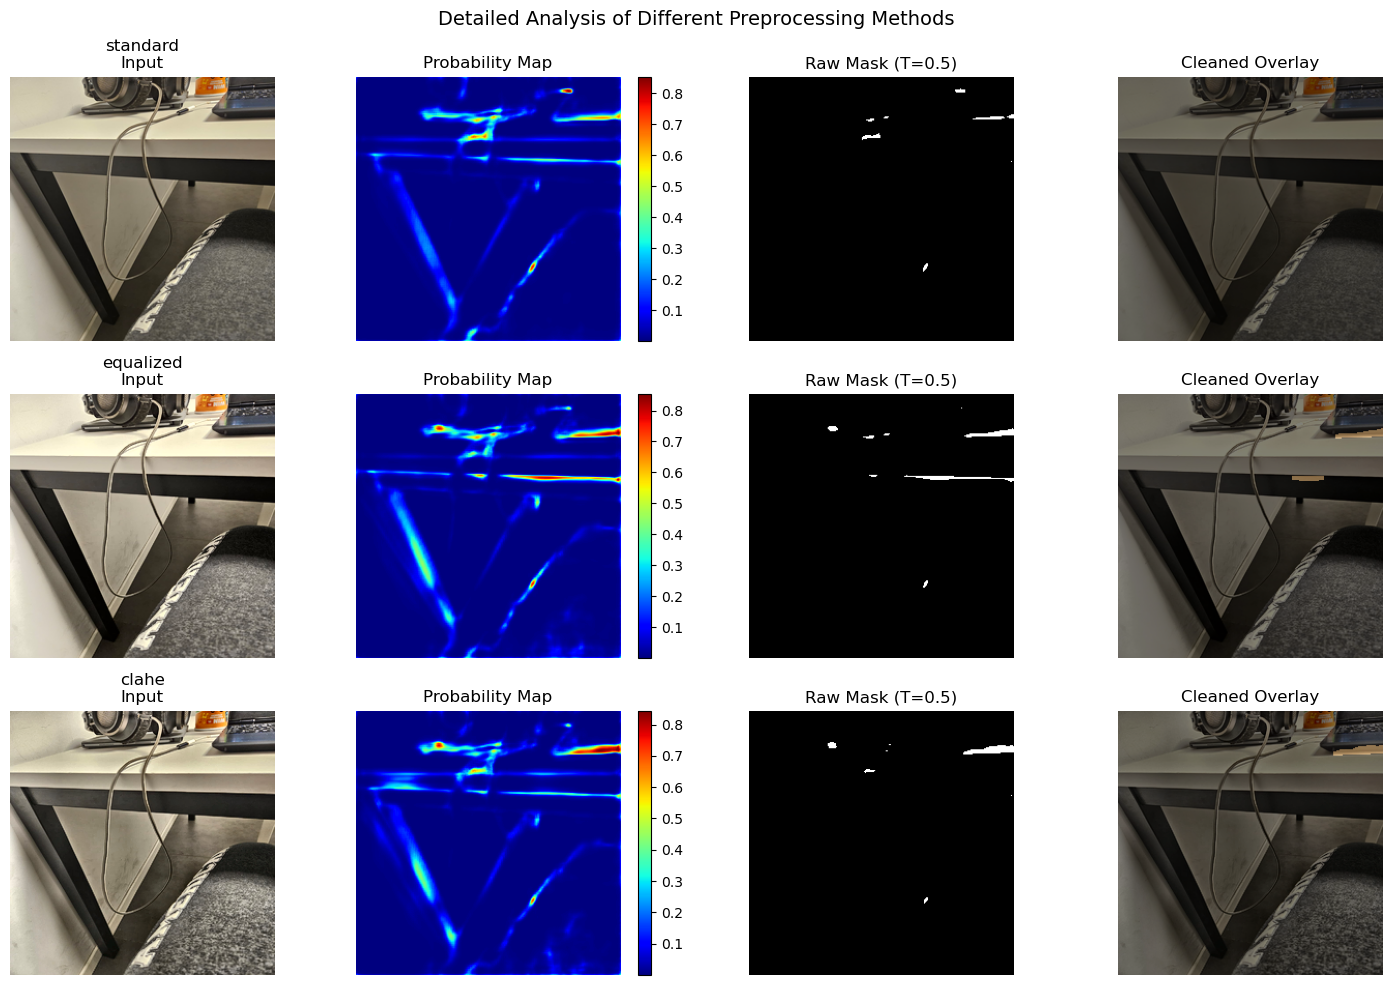


Saving individual results...


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_36400\188105902.py:324: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_img = Image.fromarray(mask_uint8, mode='L')



All results saved to diagnostic_output/

RECOMMENDATIONS
1. Check which preprocessing method works best for your specific image
2. Adjust the threshold based on the probability map visualization
3. If wires are thin, try reducing the minimum area in post-processing
4. If the model consistently fails, you may need to:
   - Retrain with images more similar to your test case
   - Use data augmentation during training
   - Collect and annotate images from your specific domain


In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.layers import Layer, Conv2D, Dropout, MaxPool2D, UpSampling2D, concatenate, Add, Multiply, BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Define custom layers (same as in training)
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        }

class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
        }

class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "bn": self.bn
        }

def analyze_image(image_path):
    """Analyze image characteristics to understand preprocessing needs"""
    image = Image.open(image_path)
    img_array = np.array(image)
    
    print("="*50)
    print("IMAGE ANALYSIS")
    print("="*50)
    print(f"Image shape: {img_array.shape}")
    print(f"Image mode: {image.mode}")
    print(f"Data type: {img_array.dtype}")
    print(f"Min pixel value: {img_array.min()}")
    print(f"Max pixel value: {img_array.max()}")
    print(f"Mean pixel value: {img_array.mean():.2f}")
    print(f"Std pixel value: {img_array.std():.2f}")
    
    # Check color distribution
    if len(img_array.shape) == 3:
        for i, channel in enumerate(['Red', 'Green', 'Blue']):
            print(f"{channel} channel - Mean: {img_array[:,:,i].mean():.2f}, Std: {img_array[:,:,i].std():.2f}")
    
    return image, img_array

def preprocess_multiple_ways(image_path, size=256):
    """Try different preprocessing methods to find what works best"""
    
    image = Image.open(image_path)
    original_size = image.size
    
    # Convert to RGB if needed
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    results = {}
    
    # Method 1: Standard normalization (as in training)
    image_resized = image.resize((size, size), Image.LANCZOS)
    results['standard'] = np.array(image_resized) / 255.0
    
    # Method 2: With histogram equalization
    img_array = np.array(image_resized)
    img_yuv = cv2.cvtColor(img_array, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    results['equalized'] = img_equalized / 255.0
    
    # Method 3: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    img_lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    results['clahe'] = img_clahe / 255.0
    
    # Method 4: Enhanced contrast
    img_pil = Image.fromarray(img_array)
    from PIL import ImageEnhance
    enhancer = ImageEnhance.Contrast(img_pil)
    img_enhanced = enhancer.enhance(1.5)
    results['enhanced_contrast'] = np.array(img_enhanced) / 255.0
    
    # Method 5: Gamma correction
    gamma = 1.2
    img_gamma = np.power(results['standard'], gamma)
    results['gamma_corrected'] = img_gamma
    
    return results, original_size

def apply_post_processing(mask, min_area=100, kernel_size=3):
    """Apply post-processing to clean up the mask"""
    
    # Convert to uint8
    mask_uint8 = (mask * 255).astype(np.uint8)
    
    # Morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Close small gaps
    mask_closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    
    # Remove small noise
    mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)
    
    # Remove small connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_opened, connectivity=8)
    
    # Create new mask keeping only larger components
    mask_filtered = np.zeros_like(mask_opened)
    for i in range(1, num_labels):  # Start from 1 to skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            mask_filtered[labels == i] = 255
    
    # Apply slight dilation to recover wire thickness
    kernel_dilate = np.ones((2, 2), np.uint8)
    mask_final = cv2.dilate(mask_filtered, kernel_dilate, iterations=1)
    
    return mask_final / 255.0

def diagnostic_segment(model_path, image_path, output_dir="diagnostic_output"):
    """
    Comprehensive diagnostic segmentation with multiple preprocessing and thresholds
    """
    
    # Create output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Analyze original image
    print("\n" + "="*50)
    print("DIAGNOSTIC WIRE SEGMENTATION")
    print("="*50)
    
    original_image, img_array = analyze_image(image_path)
    
    # Load model
    custom_objects = {
        'EncoderBlock': EncoderBlock,
        'DecoderBlock': DecoderBlock,
        'AttentionGate': AttentionGate
    }
    
    print("\nLoading model...")
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully!")
    
    # Try different preprocessing methods
    print("\nTrying different preprocessing methods...")
    preprocessed_images, original_size = preprocess_multiple_ways(image_path)
    
    # Different thresholds to try
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Store results
    all_results = {}
    
    # Process each preprocessing method
    for method_name, processed_image in preprocessed_images.items():
        print(f"\nProcessing with {method_name} preprocessing...")
        
        # Predict
        image_batch = np.expand_dims(processed_image, axis=0)
        prediction = model.predict(image_batch, verbose=0)
        prediction = np.squeeze(prediction)
        
        # Try different thresholds
        method_results = {}
        for threshold in thresholds:
            binary_mask = (prediction > threshold).astype(np.float32)
            
            # Apply post-processing
            cleaned_mask = apply_post_processing(binary_mask)
            
            method_results[threshold] = {
                'raw': binary_mask,
                'cleaned': cleaned_mask,
                'prediction': prediction
            }
        
        all_results[method_name] = method_results
    
    # Visualize all results
    print("\nGenerating diagnostic visualizations...")
    
    # Create comprehensive comparison plot
    fig = plt.figure(figsize=(20, 25))
    
    plot_idx = 1
    for method_idx, (method_name, method_results) in enumerate(all_results.items()):
        for thresh_idx, threshold in enumerate(thresholds):
            plt.subplot(len(preprocessed_images), len(thresholds), plot_idx)
            
            # Show overlay
            plt.imshow(preprocessed_images[method_name])
            plt.imshow(method_results[threshold]['cleaned'], cmap='copper', alpha=0.5)
            plt.title(f"{method_name}\nThreshold: {threshold}")
            plt.axis('off')
            plot_idx += 1
    
    plt.suptitle("Diagnostic Comparison: Different Preprocessing Methods and Thresholds", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "diagnostic_comparison.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create detailed view for best performing method
    # Let's also show probability maps
    fig2 = plt.figure(figsize=(15, 10))
    
    for idx, (method_name, method_results) in enumerate(all_results.items()):
        if idx >= 3:  # Show first 3 methods
            break
            
        # Original preprocessed image
        plt.subplot(3, 4, idx*4 + 1)
        plt.imshow(preprocessed_images[method_name])
        plt.title(f"{method_name}\nInput")
        plt.axis('off')
        
        # Probability map
        plt.subplot(3, 4, idx*4 + 2)
        plt.imshow(method_results[0.5]['prediction'], cmap='jet')
        plt.title("Probability Map")
        plt.colorbar()
        plt.axis('off')
        
        # Raw mask
        plt.subplot(3, 4, idx*4 + 3)
        plt.imshow(method_results[0.5]['raw'], cmap='gray')
        plt.title("Raw Mask (T=0.5)")
        plt.axis('off')
        
        # Cleaned mask
        plt.subplot(3, 4, idx*4 + 4)
        plt.imshow(preprocessed_images[method_name])
        plt.imshow(method_results[0.5]['cleaned'], cmap='copper', alpha=0.5)
        plt.title("Cleaned Overlay")
        plt.axis('off')
    
    plt.suptitle("Detailed Analysis of Different Preprocessing Methods", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "detailed_analysis.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save individual results
    print("\nSaving individual results...")
    for method_name, method_results in all_results.items():
        for threshold in [0.4, 0.5, 0.6]:  # Save key thresholds
            mask = method_results[threshold]['cleaned']
            mask_uint8 = (mask * 255).astype(np.uint8)
            mask_img = Image.fromarray(mask_uint8, mode='L')
            mask_img = mask_img.resize(original_size, Image.LANCZOS)
            
            filename = f"mask_{method_name}_t{threshold:.1f}.png"
            mask_img.save(os.path.join(output_dir, filename))
    
    print(f"\nAll results saved to {output_dir}/")
    
    # Print recommendations
    print("\n" + "="*50)
    print("RECOMMENDATIONS")
    print("="*50)
    print("1. Check which preprocessing method works best for your specific image")
    print("2. Adjust the threshold based on the probability map visualization")
    print("3. If wires are thin, try reducing the minimum area in post-processing")
    print("4. If the model consistently fails, you may need to:")
    print("   - Retrain with images more similar to your test case")
    print("   - Use data augmentation during training")
    print("   - Collect and annotate images from your specific domain")
    
    return all_results

def interactive_segment(model_path, image_path):
    """
    Interactive segmentation with adjustable parameters
    """
    import ipywidgets as widgets
    from IPython.display import display
    
    # Load model
    custom_objects = {
        'EncoderBlock': EncoderBlock,
        'DecoderBlock': DecoderBlock,
        'AttentionGate': AttentionGate
    }
    model = load_model(model_path, custom_objects=custom_objects)
    
    # Load and preprocess image
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_resized = image.resize((256, 256), Image.LANCZOS)
    img_array = np.array(image_resized) / 255.0
    
    # Predict
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    prediction = np.squeeze(prediction)
    
    # Create interactive widgets
    threshold_slider = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.05,
        description='Threshold:',
        continuous_update=True
    )
    
    min_area_slider = widgets.IntSlider(
        value=100,
        min=0,
        max=500,
        step=10,
        description='Min Area:',
        continuous_update=True
    )
    
    kernel_slider = widgets.IntSlider(
        value=3,
        min=1,
        max=9,
        step=2,
        description='Kernel Size:',
        continuous_update=True
    )
    
    def update_display(threshold, min_area, kernel_size):
        binary_mask = (prediction > threshold).astype(np.float32)
        cleaned_mask = apply_post_processing(binary_mask, min_area, kernel_size)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_array)
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(prediction, cmap='jet')
        plt.title(f"Probability Map")
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(img_array)
        plt.imshow(cleaned_mask, cmap='copper', alpha=0.5)
        plt.title(f"Segmentation (T={threshold:.2f})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive widget
    interactive_plot = widgets.interactive(
        update_display,
        threshold=threshold_slider,
        min_area=min_area_slider,
        kernel_size=kernel_slider
    )
    
    display(interactive_plot)

# Main execution
if __name__ == "__main__":
    # Configuration
    MODEL_PATH = "AttentionCustomUNet.h5"
    IMAGE_PATH = "2.jpeg"
    
    # Check if files exist
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file '{MODEL_PATH}' not found!")
        exit(1)
    
    if not os.path.exists(IMAGE_PATH):
        print(f"Error: Image file '{IMAGE_PATH}' not found!")
        exit(1)
    
    # Run diagnostic segmentation
    results = diagnostic_segment(MODEL_PATH, IMAGE_PATH)
    
    # Optional: Run interactive segmentation (for Jupyter notebooks)
    # Uncomment if running in Jupyter
    # interactive_segment(MODEL_PATH, IMAGE_PATH)